In [83]:
import numpy as np
z_DV, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True)

In [84]:
c=299792.458

In [85]:
z_BAO, mb, mb_err = np.loadtxt('Output/m_b_reconstruct(GPR)_results.txt', unpack=True)
z_DV = z_BAO[:3]
z_DM = z_BAO[3:]
mB_DV_bar_BAO = mb[:3]
mB_DV_bar_BAO_err = mb_err[:3]
mB_DM_bar_BAO = mb[3:]
mB_DM_bar_BAO_err = mb_err[3:]
_, H_pred_BAO, H_std_BAO = np.loadtxt('Output/Hz_DVreconstruct_results.txt', unpack=True)

In [86]:
def eta_model_constant(z, eta_0):
    return 1 + eta_0 +z*0

def eta_model_linear(z, eta_0):
    return 1 + eta_0 * z

def eta_model_fractional(z, eta_0):
    return 1 + (eta_0 * z) / (1 + z)

def eta_model_quadratic(z, eta_1, eta_2):
    return 1 + eta_1 * z + eta_2 * z**2

def eta_model_logarithmic(z, eta_0):
    return 1 + eta_0 * np.log(1 + z)

def eta_model_powerlaw(z, eps):
    return (1+z)**eps

In [87]:
def log_likelihood(eta_0, model):
    alpha1 = model(z_DM, eta_0) 
    beta1 = 10**(mB_DM_bar_BAO / 5 - 5) / (DM_rd) / (1 + z_DM)
    sigma1_eta_obs = np.sqrt((np.log(10) / 5 * mB_DM_bar_BAO_err)**2 + (DM_rd_err / DM_rd)**2)
    A1 = np.sum(alpha1**2 / (beta1**2 * sigma1_eta_obs**2))
    B1 = np.sum(alpha1 / beta1 / sigma1_eta_obs**2)
    C1 = np.sum(1 / sigma1_eta_obs**2)
    chi2_marginalized1 = C1 - B1**2 / A1 + np.log(A1 / (2 * np.pi))

    alpha2 = model(z_DV, eta_0)  
    beta2 = 10**(mB_DV_bar_BAO / 5 - 5) * z_DV**(1/2) * c**(1/2) * (DV_rd)**(-3/2) / (1 + z_DV)* H_pred_BAO**(-1/2)
    sigma2_eta_obs = np.sqrt((np.log(10) / 5 * mB_DV_bar_BAO_err)**2 + (3 * DV_rd_err / (2 * DV_rd**2))**2+(H_std_BAO/(2*H_pred_BAO))**2)
    A2 = np.sum(alpha2**2 / (beta2**2 * sigma2_eta_obs**2))
    B2 = np.sum(alpha2 / beta2 / sigma2_eta_obs**2)
    C2 = np.sum(1 / sigma2_eta_obs**2)
    
    chi2_marginalized2 = C2 - B2**2 / A2 + np.log(A2 / (2 * np.pi))
    return -0.5 * (chi2_marginalized1 + chi2_marginalized2)

def log_prior(eta_0, eta_0_bounds):
    if eta_0_bounds[0] < eta_0 < eta_0_bounds[1]:
        return 0.0
    return -np.inf

def log_posterior(eta_0, eta_0_bounds, model):
    lp = log_prior(eta_0, eta_0_bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(eta_0, model)



100%|██████████| 1000/1000 [00:02<00:00, 441.76it/s]


Linear model: eta_0 = 0.008773 ± 0.014789


100%|██████████| 1000/1000 [00:02<00:00, 428.77it/s]


Fractional model: eta_0 = 0.048950 ± 0.057088


100%|██████████| 1000/1000 [00:02<00:00, 430.31it/s]


Logarithmic model: eta_0 = 0.019982 ± 0.029645


100%|██████████| 1000/1000 [00:02<00:00, 445.37it/s]


Power law model: eta_0 = 0.021288 ± 0.028589


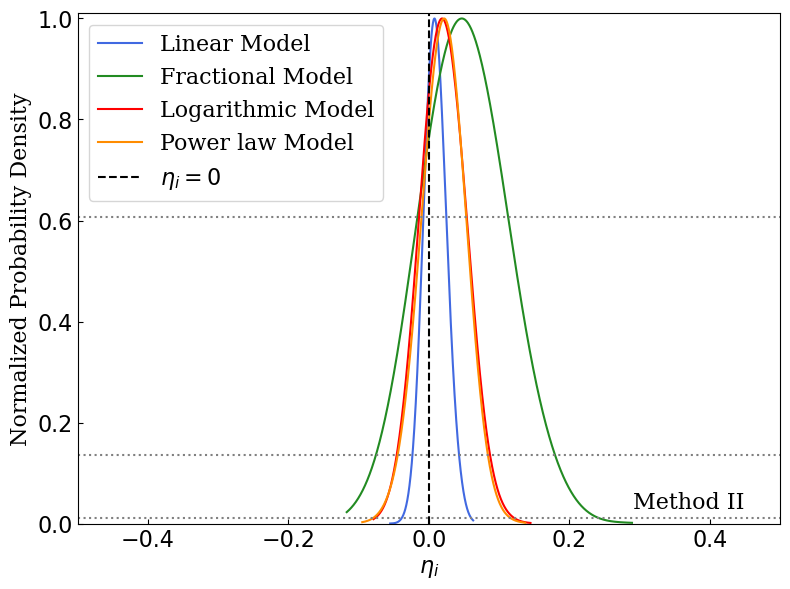

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import emcee

models = [eta_model_linear, eta_model_fractional, eta_model_logarithmic, eta_model_powerlaw]
model_names = ['Linear', 'Fractional', 'Logarithmic', 'Power law']

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['royalblue', 'forestgreen', 'red', 'darkorange']
for model, name, color in zip(models, model_names, colors):
    n_walkers = 32
    n_dim = 1
    eta_0_bounds = (-1, 1)
    initial = np.random.uniform(-0.5, 0.5, n_walkers) 
    args = (eta_0_bounds, model)

    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=args)
    sampler.run_mcmc(initial[:, np.newaxis], 1000, progress=True)


    samples = sampler.get_chain(discard=200, flat=True).flatten()
    eta_0_opt = np.median(samples)
    eta_0_err = np.percentile(samples, [16, 84])
    eta_0_err = np.diff(eta_0_err)[0] / 2


    print(f"{name} model: eta_0 = {eta_0_opt:.6f} ± {eta_0_err:.6f}")

    # alpha1 = model(z_DM, eta_0_opt)  # 模型预测 eta
    # beta1 = 10**(mB_DM_bar_BAO / 5 - 5) / (DM_rd) / (1 + z_DM)
    # sigma1_eta_obs = np.sqrt((np.log(10) / 5 * mB_DM_bar_BAO_err)**2 + (DM_rd_err / DM_rd)**2)
    # A = np.sum(beta1**2 / sigma1_eta_obs**2)
    # B = np.sum(alpha1 * beta1 / sigma1_eta_obs**2)
    # kappa_opt = A / B
    # eta_obs = beta1 / kappa_opt
    # print(f"kappa_opt = {kappa_opt:.6f}")
    # print("eta_obs:", eta_obs)

    # alpha2 = model(z_DV, eta_0_opt)  # 模型预测 eta
    # beta2 = 10**(mB_DV_bar_BAO / 5 - 5) * z_DV**(1/2) * c**(1/2) * (DV_rd)**(-3/2) / (1 + z_DV)* H_pred_BAO**(-1/2)
    # sigma2_eta_obs = np.sqrt((np.log(10) / 5 * mB_DV_bar_BAO_err)**2 + (3 * DV_rd_err / (2 * DV_rd**2))**2+(H_std_BAO/(2*H_pred_BAO))**2)
    # A2 = np.sum(beta2**2 / sigma2_eta_obs**2)
    # B2 = np.sum(alpha2 * beta2 / sigma2_eta_obs**2)
    # kappa_opt2 = A2 / B2
    # eta_obs2 = beta2 / kappa_opt2
    # print(f"kappa_opt = {kappa_opt2:.6f}")
    # print("eta_obs:", eta_obs2)

    # plt.figure(figsize=(10, 4))
    # plt.errorbar(z_DM, eta_obs, sigma1_eta_obs,fmt='o',color='blue', label='eta_obs (DM/rd)')
    # plt.errorbar(z_DV, eta_obs2, sigma2_eta_obs,fmt='o',color='green', label='eta_obs (DV/rd)')
    # z_fine = np.linspace(0, max(z_DM), 100)
    # plt.axhline(1, color='k', linestyle='--')
    # plt.plot(z_fine, model(z_fine, eta_0_opt), color='red', label=f'eta_i:{eta_0_opt:.3f}')
    # plt.fill_between(z_fine, model(z_fine, eta_0_opt) - eta_0_err*z_fine/(1+z_fine), model(z_fine, eta_0_opt) + eta_0_err*z_fine/(1+z_fine), color='red', alpha=0.2, label='1 sigma Confidence Interval')
    # plt.xlabel('z')
    # plt.ylabel(r'$\eta(z)$')
    # plt.legend()
    # plt.show()


    kde = gaussian_kde(samples, bw_method=0.5)
    x = np.linspace(min(samples), max(samples), 1000)
    y = kde(x)
    y = y / max(y)


    ax.plot(x, y, color=color, linewidth=1.5, label=f'{name} Model')

ax.set_xlim(-0.5, 0.5)  


ax.set_xlabel(r'$\eta_i$', fontsize=16, fontfamily='serif')
ax.set_ylabel('Normalized Probability Density', fontsize=16, fontfamily='serif')
# ax.set_title(r'Posterior Distribution of $\eta_i$', fontsize=16, fontfamily='serif', pad=10)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label=r'$\eta_i = 0$')

ax.axhline(y=0.60653066, color='grey', linestyle=':')
ax.axhline(y=0.13533528, color='grey', linestyle=':')
ax.axhline(y=0.011108996, color='grey', linestyle=':')

ax.set_ylim(0, 1.01)
ax.set_yticks(np.arange(0, 1.01, 0.2))

ax.tick_params(axis='both', which='major', labelsize=16, direction='in')
plt.legend(frameon=True, loc='best', prop={'family': 'serif', 'size':16})
plt.text(0.95, 0.02, "Method II", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=16, fontfamily='serif')
plt.tight_layout()
plt.savefig('fig/eta_i_posterior_methodII(GPR).pdf', bbox_inches='tight')
plt.show()

100%|██████████| 2000/2000 [00:03<00:00, 530.75it/s]


eta_0 = 0.006562 ± 0.013243
kappa = 0.019012 ± -0.001085


100%|██████████| 2000/2000 [00:03<00:00, 517.38it/s]


eta_0 = 0.025087 ± 0.024642
kappa = 0.018912 ± -0.032376


100%|██████████| 2000/2000 [00:04<00:00, 497.96it/s]


eta_0 = 0.012484 ± 0.017708
kappa = 0.018982 ± -0.011818


100%|██████████| 2000/2000 [00:03<00:00, 528.70it/s]


eta_0 = 0.012540 ± 0.017715
kappa = 0.018976 ± -0.010889


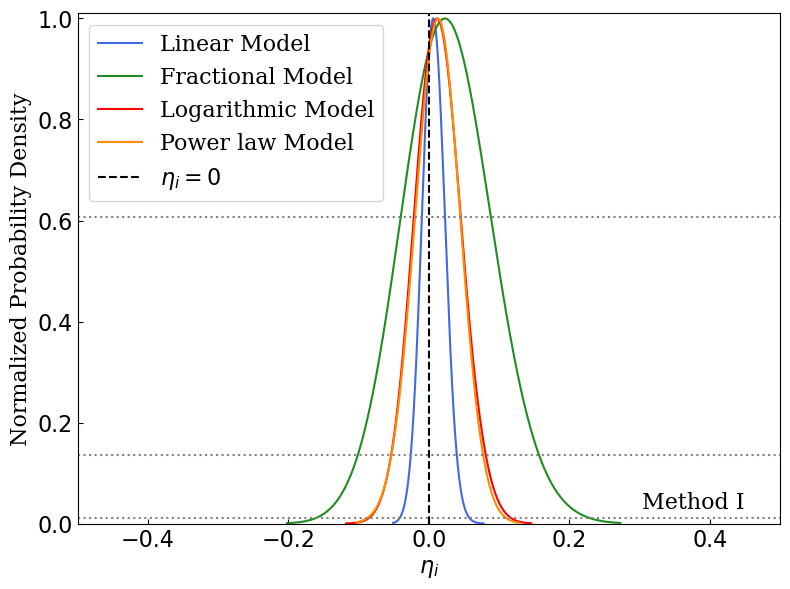

In [ ]:
def eta(z, mb, DM_rd, kappa):
    D_L = 10**(mb/5 - 5) 
    return D_L/kappa / (DM_rd*(1+z))

def eta_err(z, mb, DM_rd, mb_err, DM_rd_err, kappa):
    return eta(z, mb, DM_rd, kappa) * np.sqrt((np.log(10) / 5 * mb_err)**2 + (DM_rd_err / DM_rd)**2)

import corner
# 对kappa的后验分布进行建模
# 定义对数似然函数
def log_likelihood(theta, z, mb, DM_rd, mb_err, DM_rd_err, model):
    eta_0, kappa = theta  # 解包 eta_0 和 kappa
    eta_obs = eta(z, mb, DM_rd, kappa)
    eta_obs_err = eta_err(z, mb, DM_rd, mb_err, DM_rd_err, kappa)
    model_eta = model(z, eta_0)
    chi2 = np.sum(((model_eta-eta_obs) / eta_obs_err) ** 2)
    return -0.5 * chi2

# 定义先验
def log_prior(theta, bounds):
    eta_0, kappa = theta
    eta_0_bounds, kappa_bounds = bounds
    if eta_0_bounds[0] < eta_0 < eta_0_bounds[1] and kappa_bounds[0] < kappa < kappa_bounds[1]:
        return 0.0
    return -np.inf

# 定义后验
def log_posterior(theta, z, mb, DM_rd, mb_err, DM_rd_err, model, bounds):
    lp = log_prior(theta, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mb, DM_rd, mb_err, DM_rd_err, model)

fig_kde, ax_kde = plt.subplots(figsize=(8, 6))

# MCMC
n_walkers = 64  
n_dim = 2 
bounds = [(-0.5, 0.5), (0, 0.5)] 
initial = np.array([np.random.uniform(-0.1, 0.1, n_walkers), 
                    np.random.uniform(0, 0.5, n_walkers)]).T 
for model, name, color in zip(models, model_names, colors):
    args = (z_DM, mB_DM_bar_BAO, DM_rd, mB_DM_bar_BAO_err, DM_rd_err, model, bounds)


    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=args)
    sampler.run_mcmc(initial, 2000, progress=True)

    # 提取结果
    samples = sampler.get_chain(discard=200, flat=True)
    eta_0_opt, kappa_opt = np.median(samples, axis=0)
    eta_0_err, kappa_err = np.percentile(samples, [16, 84], axis=0)
    eta_0_err, kappa_err = np.diff(eta_0_err)[0] / 2, np.diff(kappa_err)[0] / 2

    # 输出
    print(f"eta_0 = {eta_0_opt:.6f} ± {eta_0_err:.6f}")
    print(f"kappa = {kappa_opt:.6f} ± {kappa_err:.6f}")

    # corner.corner(samples, labels=[r"$\eta_0$", r"$\kappa$"], truths=[eta_0_opt, kappa_opt], 
    #                     quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', 
    #                     plot_datapoints=False, color='black', fill_contours=True, 
    #                     levels=(0.6827, 0.9545, 0.9973))  # 1σ, 2σ, 3σ
    # plt.show()

    kde = gaussian_kde(samples[:,0], bw_method=0.5)
    x = np.linspace(min(samples[:,0]), max(samples[:,0]), 1000)
    y = kde(x)
    y = y / max(y)


    ax_kde.plot(x, y, color=color, linewidth=1.5, label=f'{name} Model')


ax_kde.set_xlim(-0.5, 0.5)
ax_kde.set_xlabel(r'$\eta_i$', fontsize=16, fontfamily='serif')
ax_kde.set_ylabel('Normalized Probability Density', fontsize=16, fontfamily='serif')
ax_kde.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label=r'$\eta_i = 0$')

ax_kde.axhline(y=0.60653066, color='grey', linestyle=':') # 对应 0.6065 (exp(-0.5))
ax_kde.axhline(y=0.13533528, color='grey', linestyle=':') # 对应 0.1353 (exp(-2))
ax_kde.axhline(y=0.011108996, color='grey', linestyle=':') # 对应 0.0111 (exp(-4.5))

ax_kde.set_ylim(0, 1.01)
ax_kde.set_yticks(np.arange(0, 1.01, 0.2))
# ax_kde.grid(True, linestyle='--', alpha=0.7)
ax_kde.tick_params(axis='both', which='major', labelsize=16, direction='in')
plt.legend(frameon=True, loc='best', prop={'family': 'serif', 'size':16})
plt.text(0.95, 0.02, "Method I", ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=16, fontfamily='serif')
plt.tight_layout()
plt.savefig('fig/eta_i_posterior_methodI(GPR).pdf', bbox_inches='tight')
plt.show() 